In [2]:
from scipy import stats
import random
from fractions import Fraction
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker

In [3]:
def safediv(n, d):
    return n/d if d!=0 else np.nan

def compute_overlap(df, close, svars):
    ser = pd.Series([safediv(sum(df[v].between(0,close)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
    ser.index = svars
    counts = pd.Series([len(df)], index=["counts"])
    ser = ser.append(counts)
    return ser 

def shuf_histplot(x, **kwargs):
    v = list(x)[1:]
#    bins = sorted(set(v))
#    interval = min([bins[i]-bins[i-1] for i,k in enumerate(bins) if i>0])
#    bins = bins + [max(v) + interval]
#    bins = [k-(interval/2) for k in bins]
    sns.histplot(v, element="step",stat="probability", 
                 common_norm=False, line_kws={'linestyle': '--'},
                 bins = 15,
                 **kwargs)#, 
    
def og_avline(x, **kwargs):
    v = list(x)
    plt.axvline(x=v[0], **kwargs)
    
def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    margin = 1e-4
    perc = stats.percentileofscore(shuf, og, kind="strict") # 
    r = sum([1 for u in v if u>=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    print(np.percentile(shuf, 2.5), np.percentile(shuf, 97.5), og)
#    print("{:.3f}".format(og-np.percentile(shuf, 97.5)),
#          "{:.3f}".format(og-np.percentile(shuf, 50)),
#          "{:.3f}".format(og-np.percentile(shuf, 2.5)))
    
    print("---")
    rnd = random.uniform(0,0.2)
    N = list(y)[0]
    ax = plt.gca()
    trans = transforms.blended_transform_factory(
    ax.transData,
    ax.transAxes  # For x
    )

    # Use the transform in the annotation
    #ax.annotate('Test', xy=(0.5, 2), xycoords=trans, ha='center', va='center')
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og + margin, 0.9), xycoords=trans, **kwargs)#0.78
    plt.annotate("n={}".format(int(N)), xy=(og +margin, 0.835), xycoords=trans, **kwargs)# 0.73

In [4]:
dat = pd.read_csv("../merged_results/results.tab.gz", sep="\t", header=None, engine="pyarrow")
dat.columns = ["chrom", "start", "end", "gc", "id", "species", "rep", "distance"]

In [7]:
sizes = dat.groupby("id").size()
sizes_df = sizes.reset_index()
sizes_df.columns = ["id", "counts"]

In [20]:
sizes_df[sizes_df.counts<245]

,id,counts
21781,Super_scaffold_355:100155028-100155289,244
21782,Super_scaffold_355:100206047-100206047,244
21783,Super_scaffold_355:100207548-100208015,244
21784,Super_scaffold_355:100233210-100233373,244
21785,Super_scaffold_355:100256898-100257058,244
...,...,...
56596,Super_scaffold_9:244341-244341,244
56597,Super_scaffold_9:33610-33610,244
56598,Super_scaffold_9:53838-53838,244
56599,Super_scaffold_9:83000-83231,244


In [64]:
res = dat[dat.gc<0.03].groupby(["species", "rep"]).apply(lambda df: compute_overlap(df, 500,["distance"]))
res = res.reset_index()

<ipython-input-3-d4a032a6ea0a>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ser = ser.append(counts)
<ipython-input-3-d4a032a6ea0a>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ser = ser.append(counts)
<ipython-input-3-d4a032a6ea0a>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ser = ser.append(counts)
<ipython-input-3-d4a032a6ea0a>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ser = ser.append(counts)
<ipython-input-3-d4a032a6ea0a>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ser = ser.append(counts)
<ipython-input-3-d4a

In [60]:
reps = dat.groupby(["species","rep"]).size().reset_index()
reps.columns = ["species", "rep", "counts"]
reps[reps.counts<50e3]

,species,rep,counts
8,corn,10,24550
9,corn,11,24547
10,corn,12,24549
11,corn,13,24545


pvalue 0.430327868852459 105 244
0.4028424502215382 0.41170182488637697 0.4078007018059562
---
pvalue 0.3877551020408163 95 245
0.23191743861848668 0.23885507942263337 0.23560129012440487
---


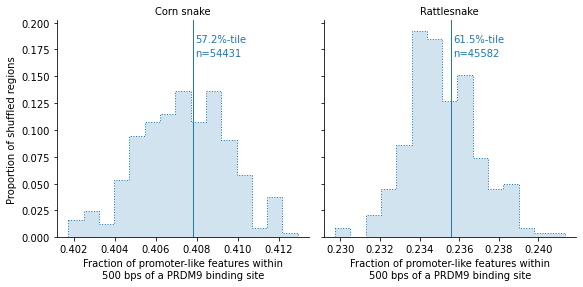

In [65]:
subd = res[~res.rep.isin([10,11,12,13])]

col_order = ["prdm9 | crossovers_far_from_cpgi","cpgi | crossovers_far_from_prdm9" ]
colors = ["blue", "orange"]
palette = {c:colors[i] for i,c in enumerate(col_order)}
g = sns.FacetGrid(data=subd, col="species", height=4.1,aspect=1, sharex=False)

g.map(shuf_histplot, "distance", alpha=0.2, linestyle="dotted")
#g.map(shuf_ecdfplot, "frac_overlap", linestyle="dotted")
#g.map(shuf_kdeplot, "frac_overlap", linestyle="dotted")
g.map(og_avline, "distance", linewidth=1)
g.map(annotate_perc, "distance", "counts", ha="left")

g.set_titles(row_template = '{row_name}')
g.set_axis_labels("Fraction of promoter-like features within\n500 bps of a PRDM9 binding site", 
                  "Proportion of shuffled regions")

labels = {"corn":"Corn snake", "rattle": "Rattlesnake"}
for species,ax in g.axes_dict.items():
    ax.set_title(labels[species], fontsize=10)
    
#g.set(xlim=(0, None))
plt.tight_layout()
plt.savefig("overlap_prom_prdm9_species_gcmatch_500bp.pdf")
plt.savefig("overlap_prom_prdm9_species_gcmatch_500bp.jpg", dpi=400)